In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [26]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import RobustScaler

In [27]:
from glob2 import glob
from numba import jit
from pandas_profiling import ProfileReport
from tqdm import tqdm

In [34]:
train_list = glob('./aT_data/data/train/*.csv')
test_list = glob('./aT_data/data/test/set_0/*.csv')

In [35]:
# feature engineering
# 함수 정의하기.

df_train = pd.DataFrame()

for i in train_list:
    group_id = i.split("_")[-1].split(".")[0]
    tmp = pd.read_csv(i)

    tmp['group_id'] = group_id
    
    df_train = pd.concat([df_train, tmp], ignore_index= True)
    
df_train

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월,group_id
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,4
1,20130102,1298.70,435.0,566065.5,3.0,350301.0,35030101.0,561.0,1587.314723,116539.0,...,1,0,0,0,0,0,0,0,0,4
2,20130103,929.07,1005.0,936562.5,5.0,350402.0,35040202.0,580.0,1731.765036,812663.0,...,1,0,0,0,0,0,0,0,0,4
3,20130104,960.96,360.0,346653.0,4.0,340101.0,34010102.0,330.0,1433.421743,282245.0,...,1,0,0,0,0,0,0,0,0,4
4,20130105,720.72,5400.0,3903900.0,1.0,311201.0,31120103.0,467.0,1549.518789,347766.0,...,1,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,9
54053,20161228,1181.18,1872.0,2203201.0,12.0,310101.0,31010102.0,461,1045.424358,642449.0,...,0,0,0,0,0,0,0,0,0,9
54054,20161229,1131.13,14040.0,15860124.0,20.0,360301.0,36030102.0,800,1034.546961,479628.0,...,0,0,0,0,0,0,0,0,0,9
54055,20161230,1231.23,4407.0,5434060.5,22.0,220001.0,22000105.0,903,1045.917875,534612.0,...,0,0,0,0,0,0,0,0,0,9


In [36]:
df_test = pd.read_csv(test_list[0])
df_test.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_0_습도(%)', '주산지_1_초기온도(℃)',
       '주산지_1_최대온도(℃)', '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)',
       '주산지_1_습도(%)', '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_2_평균온도(℃)', '주산지_2_강수량(ml)', '주산지_2_습도(%)', '일자구분_중순', '일자구분_초순',
       '월구분_1월'],
      dtype='object')

In [67]:
df_test['group_id'] = str(0)

In [65]:
df_train.columns

Index(['datadate', '단가(원)', '거래량', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)',
       '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
       '일자별_도매가격_최대(원)', '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)',
       '일자별_소매가격_평균(원)', '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)',
       '수입금액(달러)', '무역수지(달러)', 'group_id', 'datetime', 'cos_time', '주산지_초기온도',
       '주산지_최대온도', '주산지_최저온도', '주산지_평균온도', '주산지_강수량'],
      dtype='object')

In [38]:
def feature_engineer(df):
       # 시간 코사인 인코딩
       df['datetime'] = pd.to_datetime(df['datadate'], format="%Y%m%d")
       df['cos_time'] = np.cos(2*np.pi*df['datetime'].dt.dayofyear/365)

       # 결측치
       df = df.replace(' ', np.nan)
       
       # 주산지 초기온도, 최대온도, 최저온도, 평균온도, 강수량, 습도
       df['주산지_초기온도'] = (df['주산지_0_초기온도(℃)'] + df['주산지_1_초기온도(℃)'] + df['주산지_2_초기온도(℃)'])/3
       df['주산지_최대온도'] = (df['주산지_0_최대온도(℃)'] + df['주산지_1_최대온도(℃)'] + df['주산지_2_최대온도(℃)'])/3
       df['주산지_최저온도'] = (df['주산지_0_최저온도(℃)'] + df['주산지_1_최저온도(℃)'] + df['주산지_2_최저온도(℃)'])/3
       df['주산지_평균온도'] = (df['주산지_0_평균온도(℃)'] + df['주산지_1_평균온도(℃)'] + df['주산지_2_평균온도(℃)'])/3
       df['주산지_강수량'] = (df['주산지_0_강수량(ml)'] + df['주산지_1_강수량(ml)'] + df['주산지_2_강수량(ml)'])/3

       # 필요없는 컬럼 제거
       trunc_columns = ['거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ','일자구분_중순', '일자구분_초순',
       '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월',
       '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월',
       '주산지_0_초기온도(℃)', '주산지_1_초기온도(℃)', '주산지_2_초기온도(℃)',
       '주산지_0_최대온도(℃)', '주산지_1_최대온도(℃)', '주산지_2_최대온도(℃)',
       '주산지_0_최저온도(℃)', '주산지_1_최저온도(℃)', '주산지_2_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_1_평균온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_0_강수량(ml)', '주산지_1_강수량(ml)', '주산지_2_강수량(ml)',
       '주산지_0_습도(%)', '주산지_1_습도(%)', '주산지_2_습도(%)']

       df = df[[c for c in df.columns if c not in trunc_columns]]

       return df



In [39]:
df_train = feature_engineer(df_train)
df_train

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),상위가격 평균가(원),하위가격 거래물량(kg),상위가격 거래물량(kg),일자별_도매가격_최대(원),...,수입금액(달러),무역수지(달러),group_id,datetime,cos_time,주산지_초기온도,주산지_최대온도,주산지_최저온도,주산지_평균온도,주산지_강수량
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89161.0,6636713.0,4,2013-01-01,0.999852,1.433333,9.600000,-1.100000,4.466667,0.000000
1,20130102,1298.70,435.0,1587.314723,116539.0,1192.610955,2047.122982,62709.0,53830.0,45000.0,...,89161.0,6636713.0,4,2013-01-02,0.999407,4.333333,11.333333,2.500000,7.466667,0.000000
2,20130103,929.07,1005.0,1731.765036,812663.0,1420.352265,2046.621791,408566.0,404097.0,45000.0,...,89161.0,6636713.0,4,2013-01-03,0.998667,3.066667,10.300000,0.033333,4.633333,0.000000
3,20130104,960.96,360.0,1433.421743,282245.0,1108.175190,1802.850161,150098.0,132147.0,45000.0,...,89161.0,6636713.0,4,2013-01-04,0.997630,3.066667,10.833333,-0.733333,5.000000,0.000000
4,20130105,720.72,5400.0,1549.518789,347766.0,1231.243133,1950.208595,193815.0,153951.0,45000.0,...,89161.0,6636713.0,4,2013-01-05,0.996298,1.566667,8.166667,0.433333,4.166667,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54052,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22360318.0,-22360318.0,9,2016-12-27,0.998667,0.866667,9.333333,-1.200000,3.933333,0.000000
54053,20161228,1181.18,1872.0,1045.424358,642449.0,942.313948,1178.813959,362351.0,280098.0,20600.0,...,22360318.0,-22360318.0,9,2016-12-28,0.999407,2.833333,12.600000,-2.200000,4.266667,0.000000
54054,20161229,1131.13,14040.0,1034.546961,479628.0,948.947250,1150.786982,276219.0,203409.0,20600.0,...,22360318.0,-22360318.0,9,2016-12-29,0.999852,0.733333,9.033333,-4.166667,2.400000,0.466667
54055,20161230,1231.23,4407.0,1045.917875,534612.0,969.206041,1161.925409,321810.0,212802.0,20000.0,...,22360318.0,-22360318.0,9,2016-12-30,1.000000,0.133333,-0.366667,-10.200000,-6.366667,0.500000


In [40]:
df_train = df_train.fillna(0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54057 entries, 0 to 54056
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datadate         54057 non-null  int64         
 1   단가(원)            54057 non-null  float64       
 2   거래량              54057 non-null  float64       
 3   해당일자_전체평균가격(원)   54057 non-null  float64       
 4   해당일자_전체거래물량(kg)  54057 non-null  float64       
 5   하위가격 평균가(원)      54057 non-null  float64       
 6   상위가격 평균가(원)      54057 non-null  float64       
 7   하위가격 거래물량(kg)    54057 non-null  float64       
 8   상위가격 거래물량(kg)    54057 non-null  float64       
 9   일자별_도매가격_최대(원)   54057 non-null  float64       
 10  일자별_도매가격_평균(원)   54057 non-null  float64       
 11  일자별_도매가격_최소(원)   54057 non-null  float64       
 12  일자별_소매가격_최대(원)   54057 non-null  float64       
 13  일자별_소매가격_평균(원)   54057 non-null  float64       
 14  일자별_소매가격_최소(원)   54057 non-null  float

In [69]:
prediction_length = 28
encoder_length = 14
X_columns = ['단가(원)', '거래량', '해당일자_전체거래물량(kg)',
       '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
       '일자별_도매가격_최대(원)', '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)',
       '일자별_소매가격_평균(원)', '일자별_소매가격_최소(원)', 'cos_time', '주산지_초기온도', '주산지_최대온도',
       '주산지_최저온도', '주산지_평균온도', '주산지_강수량']

training = TimeSeriesDataSet(
    df_train[:-28],
    time_idx="datadate",
    target="해당일자_전체평균가격(원)",
    group_ids=["group_id"],
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length-1,
    static_categoricals=["group_id"],
    # time_varying_known_categoricals=X_columns,
    time_varying_known_reals=X_columns,
    target_normalizer=GroupNormalizer(
        groups=["group_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    # scalers = EncoderNormalizer(),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
    
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [70]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

992.4351806640625

In [71]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    # gpus=1,
    # accelerator="mps", 
    # devices=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 45.1k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /Users/chai/myRepo/Competitions/nongnet/.lr_find_a532d14e-9be3-40f0-b1a3-0489dbd051b1.ckpt


suggested learning rate: 0.041686938347033554


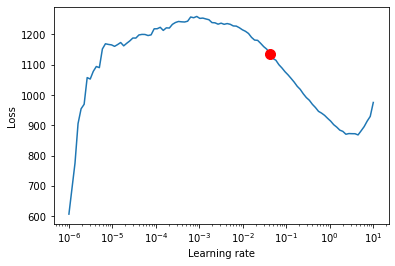

In [72]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [73]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=28,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/Users/chai/miniforge3/envs/nnenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 45.5k


In [74]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 444   
3  | prescalers                         | ModuleDict                      | 368   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 14.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [75]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [76]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(94.3442)

In [77]:
test_list = glob('./aT_data/data/test/set_1/*.csv')
df_test = pd.read_csv(test_list[0])

df_test = feature_engineer(df_test)
df_test

,datadate,단가(원),거래량,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),상위가격 평균가(원),하위가격 거래물량(kg),상위가격 거래물량(kg),일자별_도매가격_최대(원),...,수입중량(kg),수입금액(달러),무역수지(달러),datetime,cos_time,주산지_초기온도,주산지_최대온도,주산지_최저온도,주산지_평균온도,주산지_강수량
0,20170226,2597.40,252.0,1999.077583,182741.0,1580.565637,2418.520380,91472.0,91269.0,13000.0,...,NaN,NaN,NaN,2017-02-26,0.556017,0.366667,9.800000,-2.466667,3.566667,0.000000
1,20170227,1541.54,70.0,1940.740624,198469.0,1557.462695,2368.759247,104707.0,93762.0,NaN,...,NaN,NaN,NaN,2017-02-27,0.541628,0.933333,10.033333,-0.900000,4.466667,0.600000
2,20170228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2017-02-28,0.527078,2.833333,9.533333,0.133333,5.600000,0.666667
3,20170301,620.62,80.0,2054.058569,233421.0,1658.672927,2460.878216,118374.0,115047.0,NaN,...,NaN,NaN,NaN,2017-03-01,0.512371,5.266667,5.966667,-2.333333,1.833333,40.366667
4,20170302,1981.98,292.0,2073.866690,203541.0,1615.181770,2535.177704,102061.0,101480.0,15000.0,...,NaN,NaN,NaN,2017-03-02,0.497513,-3.100000,2.566667,-4.300000,-0.466667,50.000000
5,20170303,2382.38,40.0,1997.451460,219305.0,1556.459276,2501.658026,116986.0,102319.0,14000.0,...,NaN,NaN,NaN,2017-03-03,0.482508,-3.566667,5.366667,-5.000000,0.033333,0.333333
6,20170304,2607.39,24.0,1968.545825,193849.0,1568.182955,2407.735777,101407.0,92442.0,13300.0,...,NaN,NaN,NaN,2017-03-04,0.467359,-0.866667,8.400000,-0.833333,3.766667,0.000000
7,20170305,1451.45,60.0,2181.100469,199588.0,1750.080471,2632.610908,102111.0,97477.0,16000.0,...,NaN,NaN,NaN,2017-03-05,0.452072,1.500000,12.800000,0.200000,6.900000,0.000000
8,20170306,1901.90,1368.0,2987.253790,203557.0,2169.169746,3892.709979,106938.0,96619.0,NaN,...,NaN,NaN,NaN,2017-03-06,0.436651,3.933333,7.900000,-1.566667,1.566667,5.866667
9,20170307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2017-03-07,0.421101,-0.566667,7.300000,-2.066667,1.900000,7.166667


In [78]:
best_tft.predict(df_test)

KeyError: 'variable group_id specified but not found in data'